Deep Learning
=============

Assignment 5
------------

The goal of this assignment is to train a skip-gram model over [Text8](http://mattmahoney.net/dc/textdata) data.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Download the data from the source website if necessary.

In [2]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


Read the data into a string.

In [3]:
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words"""
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data
  
words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


Build the dictionary and replace rare words with UNK token.

In [4]:
vocabulary_size = 50000

def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5239, 3084, 12, 6, 195, 2, 3137, 46, 59, 156]


Function to generate a training batch for the skip-gram model.

In [5]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with num_skips = 2 and skip_window = 1:
    batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']
    labels: ['as', 'anarchism', 'a', 'originated', 'term', 'as', 'of', 'a']

with num_skips = 4 and skip_window = 2:
    batch: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a']
    labels: ['anarchism', 'a', 'originated', 'term', 'term', 'of', 'originated', 'as']


Train a skip-gram model.

In [6]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, embed,
                               train_labels, num_sampled, vocabulary_size))

  # Optimizer.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between validation examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [7]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(
      batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 7.997398
Nearest to time: reneged, spoon, sodomy, affections, eurasian, kajang, serene, detectable,
Nearest to with: dispatches, teos, merritt, strumming, kohlrabi, agena, sienkiewicz, upanija,
Nearest to UNK: exemplary, deus, shields, obligations, castilian, topography, inexact, enzo,
Nearest to also: vince, lara, shamash, deriving, pneumonic, potable, rarer, cane,
Nearest to from: falk, fide, salinger, rico, ponder, discarded, bombarding, twilight,
Nearest to there: dependents, ahaziah, apollodorus, reals, disloyalty, crist, dhea, mandible,
Nearest to at: simpler, notorious, halal, horsemanship, optimates, misleadingly, garbled, fleet,
Nearest to first: disparaging, mcfadden, georges, disembarked, infamy, monorail, bruce, weblogs,
Nearest to than: anni, mixtures, pang, shield, desolate, mus, castilla, cute,
Nearest to between: textrm, abernethy, unverified, entice, heavy, anyway, habit, filmmakers,
Nearest to will: tried, dred, mutton, symplectic, 

In [8]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

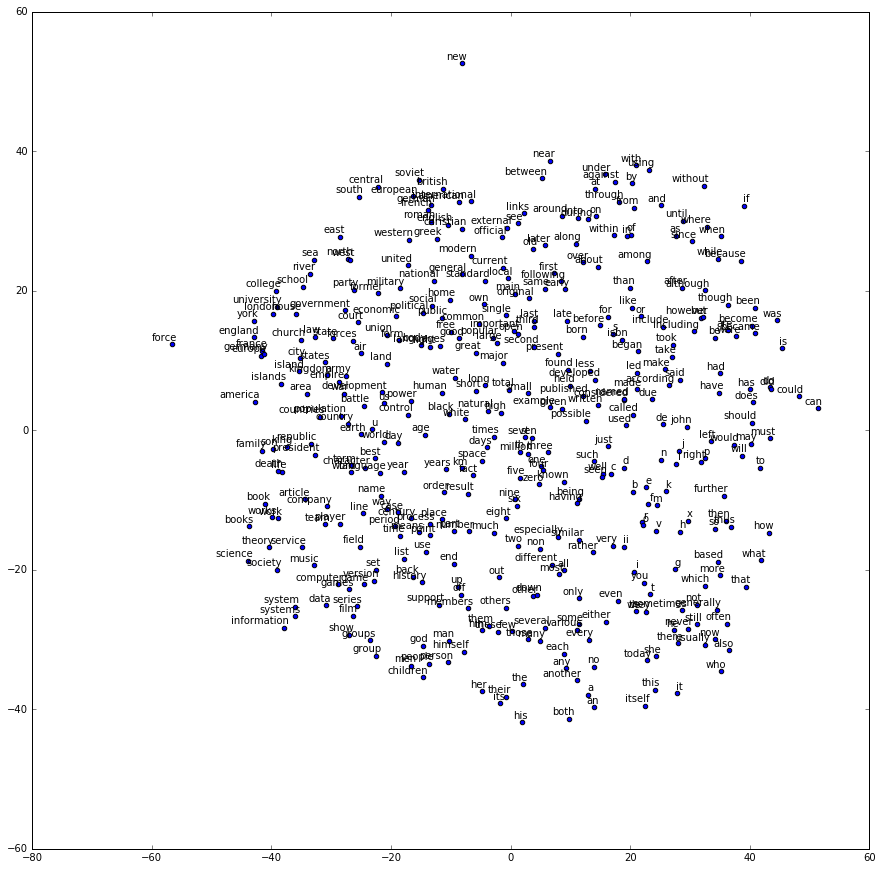

In [9]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

---

Problem
-------

An alternative to Word2Vec is called [CBOW](http://arxiv.org/abs/1301.3781) (Continuous Bag of Words). In the CBOW model, instead of predicting a context word from a word vector, you predict a word from the sum of all the word vectors in its context. Implement and evaluate a CBOW model trained on the text8 dataset.

---

---
Answer
======

A good article that finally helped me understand which elements were the vectors and how to implement CBOW was [Word2Vec Parameter Learning Explained](http://www-personal.umich.edu/~ronxin/pdf/w2vexp.pdf).

The vector we are creating for each word is the i'th row of the weight matrix (for the i'th word, since the input vector is a one-hot encoding of all the possible words with just the i'th word as a 1 and all the rest 0).  Since the activation function between the input and the hidden layer is just a linear function (i.e. inputxW) that means the i'th row of the weight matrix basically gets copied as is to the hidden layer (because all the other rows of the weight matrix get zero'd out when multiplied by the zero elements of the one-hot input vector).  So the 'vector' that we are mapping each word to is the i'th row of the weight matrix (assuming we are talking about the i'th word).  That i'th row also happens to be the single column of the hidden layer (*assuming* that we just have a single context input in the CBOW model -- if we have multiple context inputs for each predicted target, then the hidden layer is an average of all the vectors of the context words, as discussed below).

For the CBOW model, we use the *context* words (i.e. surrounding words) as the input and try to predict the target (or 'center' word inside the context window).  The word2vec skip-gram model is the opposite where it uses the single 'target' word as the input and tries the predict all the 'context' words within a certain window size.  

In the simplest case of the CBOW model, let's assume that the 'window' for the context is just the one word following the target -- a single context word.  In that case, the one-hot input vector is that single context word and the linear activation function will simply copy the vector encoding of that word (the i'th row of the 'input' weight matrix) into the hidden layer.  Then the next calculation will multiply the hidden layer by an 'output' weight matrix which will give an softmax output of which vocabulary words it predicts are the target word (note that the softmax output is the size of the vocabulary, just like the input was a one-hot encoding the size of the vocabulary, so they are the same size -- the hidden layer is any size we choose though).

The 'vector' that we are mapping each word to is actually two different vectors:  there is the 'input' vector which is the i'th row of the input weight matrix, and the 'output' vector which is the i'th row of the output weight matrix.

For more complex (and typical) CBOW models, we'll have a larger window and multiple context words as the input.  The way this is handled is that we compute the vector for each input context word (i.e. just multiply it's one-hot input vector times the input weight matrix, yielding the vector for that input word -- or the i'th row of the input weight matrix) and then average them all by adding them and dividing by the number of input words.  So, if we have a 'window' which is the two words before and the two words after a target word, we'll have 4 context words for input to predict a target word.  These 4 input words are each computed for their input vector and then those are added and the result is divided by 4 -- that is the column of values that becomes our hidden layer.

---

Very useful post from the Udacity forums:
=========================================

What is the difference between Skip-gram and CBOW?
==================================================
So as most have mentioned, the main difference between skip-gram and CBOW is that the inputs and outputs are reversed - For skip-gram you input a word and then train the embedding representation be close to the words either side as possible. With CBOW, the words around the target are used as the input and they summed together to create a single target embedding. Here the training is to make the combination of these "context" words result as closely as possible to the target word.

So, lets start by looking at the skip-gram batch generation
===========================================================
The code supplied generates a skip-gram model and this is our starting point, so it's important to understand what's going on here. The generate_batch function generates both the input to the model and the target labels for the output. So in the example usage, batch_size = 8, num_skips = 2 and skip_window = 1. this then produces the following output:

batch: [originated, originated, as, as, a, a, term, term]
labels: [anarchism, as, a, originated, as, term, a, of]
As can clearly be seen, the batch contains duplicated input which is then given a different label. when the batch is passed to tf.nn.embedding_lookup, the matrix returned is [batch_size, embedding_size] where each row corresponds to the embedding for the word in that position the batch. These are then compared directly against the label in the same row for learning. This produces this behaviour of learning a single word being as close as possible to the context words around it.

How to move from skip-gram to CBOW
==================================
In CBOW the labels and batches are reversed. However, this is not where the change ends. CBOW words by summing the words around the target to generate the vector for the target. This means that the output size of the model is reduced from being batch_size outputs, to being batch_size/context_window where context_window is the number of words either side of the target to be used to train (i.e. context_window = 2 * skip_window).

So lets look at generating the batch for CBOW. Now, as there are less outputs, we can generate a smaller number of labels to be passed to training as there are less outputs from the model. So instead of generating batch_size batch inputs and labels, we will generate batch_size batch inputs and batch_size/context_window labels. This gives us an output like this:

batch: [anarchism, as, a, originated, as, term, of, a]
labels: [originated, as, a, term]
Next using tf.nn.embedding_lookup the embeddings from batch can be retrieved. Again the output is [batch_size, embedding_size] and it needs to be reduced. This is done by summing context_window segments of the output matrix together, resulting in a [batch_size/context_window, embedding_size] matrix that then can be passed on to training just as in the skip_gram model.

How do you do the reduction of the embedding matrix in TensorFlow?
==================================================================
So, anyone who has messed around with TensorFlow for a while might notice, you cannot do direct assignment to TensorFlow variables. So, instead a function that operates on the Tensor is needed. Fortunately TensorFlow has a function called tf.segment_sum6 which can sum segements of a Tensor, resulting in a reduction of the number of columns and works just as required by this task.

Once Implemented, The average loss had dropped below 3 by step 6000 and went down to a low of 2.1. This far outperformed the skip-gram model that in 100,000 steps did not achieve an average loss below 3.



Here is a modified batch generation function for generating CBOW batches.  It basically swaps the 'batch' and 'label' outputs so that 'batch' are the multiple 'context' words for input and 'label' is the correct 'target' output that we want the model to predict.

In [10]:
data_index = 0
num_context_words = 2
win_size_on_either_size = 1

def generate_cbow_batch(batch_size, num_context_words, win_size_on_either_side):
    '''
    Generate a 'batch' vector that is size 'batch_size' (but with the understanding that the first 'num_context_words'
      elements map to the first element of the label vector)
    Generate a 'label' vector that is size 'batch_size'/'num_context_words'. (Note that batch_size must be a multiple
      of num_context_words).  Also, it must be true that num_context_words = 2*win_size_on_either_side.
    
    The 'batch' vector represent the surrounding 'context' words around a 'target' and there are multiple of these
      'context' words that are used (by looking up their embeddings and then summing) to create the hidden layer
      of the model.  the 'label' is then the expected output of the model.  That is why the 'batch' vector is larger
      than the 'label' vector -- because multiple 'batch' input values are used for each 'label' output.
    '''
    global data_index
    assert batch_size % num_context_words == 0
    assert num_context_words <= 2 * win_size_on_either_side
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size//num_context_words, 1), dtype=np.int32)
    span = 2 * win_size_on_either_side + 1 # [ win_size_on_either_side target win_size_on_either_side ]
    buffer = collections.deque(maxlen=span)
    label_index = 0
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size // num_context_words):
        target = x = win_size_on_either_side  # target label at the center of the buffer
        indicies_to_avoid = [ target ]
        for j in range(num_context_words):
            while x in indicies_to_avoid:
                x = random.randint(0, span - 1)
            indicies_to_avoid.append(x)
            batch[i * num_context_words + j] = buffer[x]
        labels[label_index, 0] = buffer[target]
        label_index = (label_index +1) % (batch_size//num_context_words)
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_context_words, win_size_on_either_side in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_cbow_batch(batch_size=8, num_context_words=num_context_words, 
                                        win_size_on_either_side=win_size_on_either_side)
    print('\nwith num_context_words = %d and win_size_on_either_side = %d:' % (num_context_words, 
                                                                               win_size_on_either_side))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li[0]] for li in labels])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with num_context_words = 2 and win_size_on_either_side = 1:
    batch: ['as', 'anarchism', 'originated', 'a', 'term', 'as', 'of', 'a']
    labels: ['originated', 'as', 'a', 'term']

with num_context_words = 4 and win_size_on_either_side = 2:
    batch: ['a', 'anarchism', 'originated', 'term', 'of', 'term', 'originated', 'as']
    labels: ['as', 'a']


Create the CBOW Model

In [11]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
win_size_on_either_side = 1 # How many words to consider left and right.
num_context_words = 2 # How many context words we use as input to generate a single label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

    # Input data.
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size//num_context_words, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

    # Variables.
    # DAY -- this 'embeddings' variable is also just the input weights for the input -> hidden_layer
    #        linear function.  Each row of the embeddings is a word vector, so the i'th row of embeddings
    #        is the word vector we are creating for the i'th word in our vocabulary.
    #        If this 'embeddings' is really just a weight matrix for the input, you might ask if we also
    #        have a biases matrix for the input and the answer is no because we just assume it is zero.
    #        Hence the normal linear activation function of input x weights + biases really becomes just
    #        a lookup of the i'th row of the weights (or 'embeddings') since the input is a one-hot vector.
    embeddings = tf.Variable(
        tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    # segment_ids will be used with tf.segment_sum()
    segment_ids = np.ndarray(shape=(batch_size), dtype=np.int32)
    for i in range(batch_size//num_context_words):
        for j in range(num_context_words):
            segment_ids[i*num_context_words +j] = i
    print('segment_ids = %s' % segment_ids)
    #segment_ids = tf.constant(segment_ids, dtype=tf.int32)
    
    # DAY -- these weights and biases are for the second step of the model:  from hidden_layer -> output
    softmax_weights = tf.Variable(
        tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))

    # Model.
    # Look up embeddings for inputs.  This input is of size batch_size and is understood to have 
    # num_context_words entries for each single output it will generate.  We will look up the 
    # embeddings for all and then combine each set of num_context_words entries into a single
    # entry for use in the model by using tf.segment_sum().
    embed = tf.nn.embedding_lookup(embeddings, train_dataset)
    # embed is size (batch_size, embedding_size)
    #print('embed size = %s' % embed.get_shape())
    embed_summed = tf.segment_sum(embed, segment_ids)
    print('embed_summed size = %s' % embed_summed.get_shape())
    # embed_summed is now our hidden layer and has size of [batch_size//num_context_words, embedding_size]
    # Compute the softmax loss, using a sample of the negative labels each time.
    loss = tf.reduce_mean(
        tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, embed_summed,
                               train_labels, num_sampled, vocabulary_size))

    # Optimizer.
    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)

    # Compute the similarity between minibatch examples and all embeddings.
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(
        normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

segment_ids = [ 0  0  1  1  2  2  3  3  4  4  5  5  6  6  7  7  8  8  9  9 10 10 11 11 12
 12 13 13 14 14 15 15 16 16 17 17 18 18 19 19 20 20 21 21 22 22 23 23 24 24
 25 25 26 26 27 27 28 28 29 29 30 30 31 31 32 32 33 33 34 34 35 35 36 36 37
 37 38 38 39 39 40 40 41 41 42 42 43 43 44 44 45 45 46 46 47 47 48 48 49 49
 50 50 51 51 52 52 53 53 54 54 55 55 56 56 57 57 58 58 59 59 60 60 61 61 62
 62 63 63]
embed_summed size = (?, 128)


Now train that CBOW model

In [12]:
num_steps = 100001

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print('Initialized')
    average_loss = 0
    for step in range(num_steps):
        batch_data, batch_labels = generate_cbow_batch(batch_size=batch_size, num_context_words=num_context_words, 
                                            win_size_on_either_side=win_size_on_either_side)
        feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += l
        if step % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print('Average loss at step %d: %f' % (step, average_loss))
            average_loss = 0
        # note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in xrange(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log = 'Nearest to %s:' % valid_word
                for k in xrange(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = '%s %s,' % (log, close_word)
                print(log)
    final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 7.856272
Nearest to an: gq, rieure, quincy, castlereagh, assistive, poirot, diligence, grover,
Nearest to was: purists, godless, vall, fall, assistants, immortality, shen, observances,
Nearest to such: schindler, codepages, shake, extraneous, narrowest, subarctic, moriarty, xxix,
Nearest to b: jars, pitting, placentia, parole, quaternion, shrewsbury, xanadu, minerals,
Nearest to there: existed, indexing, representatives, sketchy, strives, strategist, caveat, lactation,
Nearest to three: feel, varies, queries, sheaf, bluff, dent, moser, beginnings,
Nearest to history: pharos, personae, flagellate, deutschlands, busta, spans, announces, yangtze,
Nearest to during: embryonic, parthia, gunman, scarecrow, vert, echelon, adaption, functionally,
Nearest to five: uncanny, pritchard, nineteenth, colloquialism, roofs, unbelievable, langue, marginalism,
Nearest to most: azo, cobra, cambodia, clytemnestra, vending, meta, drenched, django,
Nearest to two: observe

In [13]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

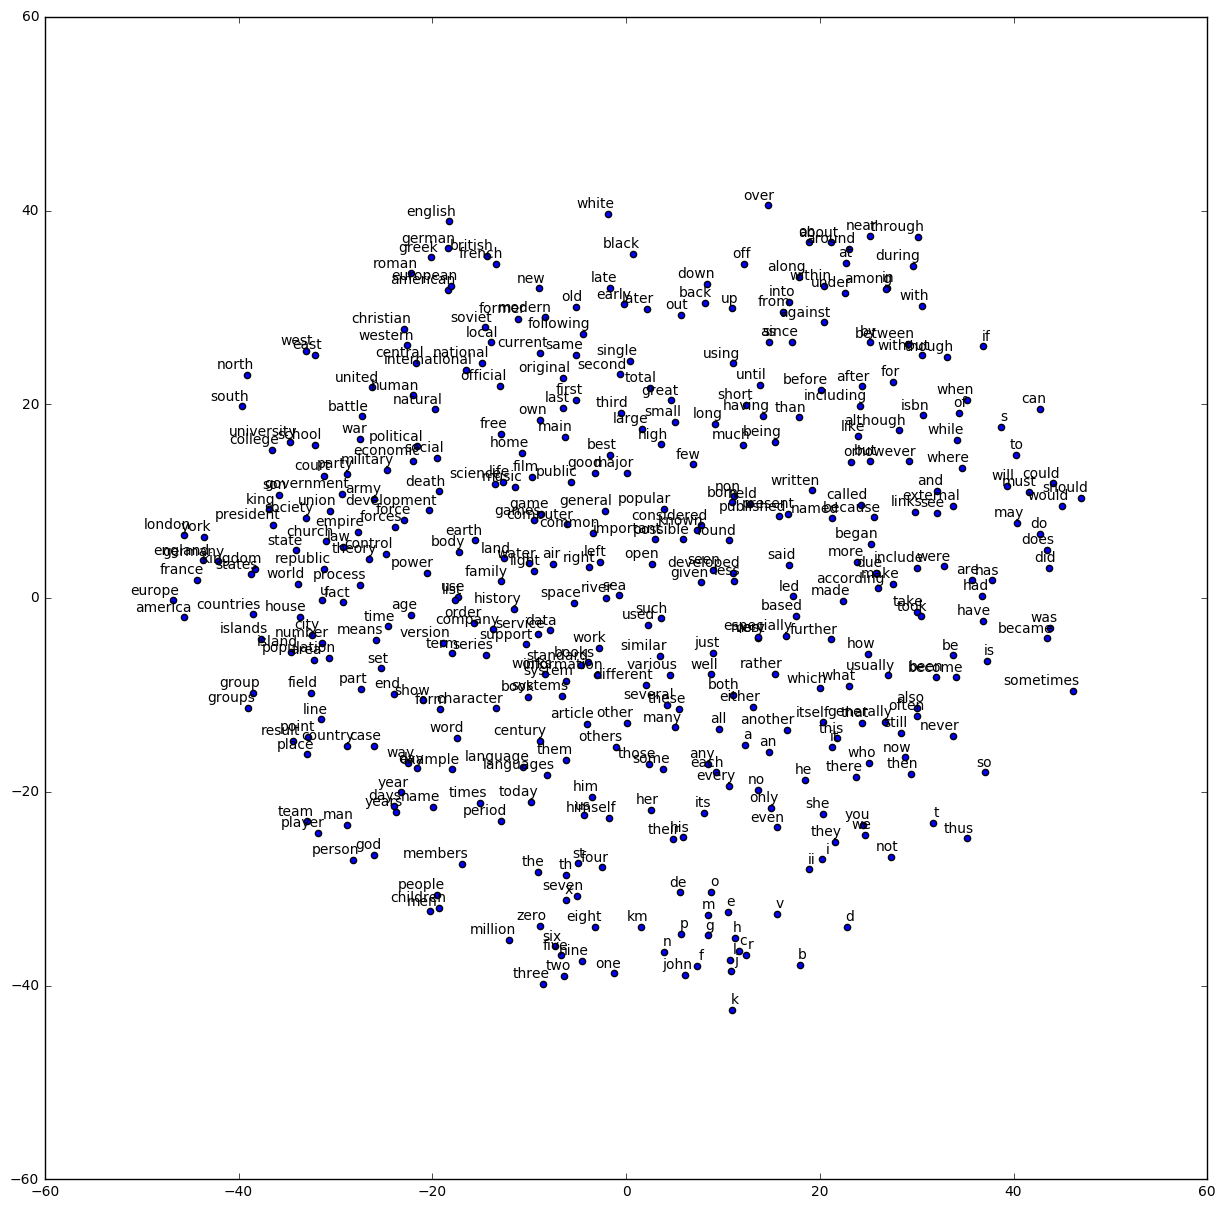

In [14]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

%matplotlib inline

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)